In [1]:
# import the general stuff
import os
from os import getcwd
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sklearn import metrics

#import stuff for gradCAM
import matplotlib.cm as cm
from IPython.display import Image

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.3.0


In [2]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

 GPU: /device:GPU:0


In [3]:
# define a callback

callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_acc', 
                                             patience = 30, 
                                             restore_best_weights = True)

In [4]:
# Define dirs and files
train_dir = '../data/training/'
validation_dir = '../data/validation/'

train_wash_dir = os.path.join(train_dir,'wash')
train_nowash_dir = os.path.join(train_dir,'nowash')
validation_wash_dir = os.path.join(validation_dir,'wash')
validation_nowash_dir = os.path.join(validation_dir,'nowash')

train_wash_fnames = os.listdir(train_wash_dir)
train_nowash_fnames = os.listdir(train_nowash_dir)
validation_wash_fnames = os.listdir(validation_wash_dir)
validation_nowash_fnames = os.listdir(validation_nowash_dir)


print(len(os.listdir(train_wash_dir)))
print(len(os.listdir(train_nowash_dir)))
print(len(os.listdir(validation_wash_dir)))
print(len(os.listdir(validation_nowash_dir)))

total_train=len(os.listdir(train_wash_dir))+ len(os.listdir(train_nowash_dir))
total_val=len(os.listdir(validation_wash_dir))+ len(os.listdir(validation_nowash_dir))

143
167
36
42


In [5]:
#build data generators for training and validaton

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator( rescale =1./255.,
                                   rotation_range = 90,
                                   width_shift_range = 0.5,
                                   height_shift_range = 0.5,
                                   shear_range = 0.45,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True)

# rescale val data
val_datagen = ImageDataGenerator( rescale =1./255.,
                                   rotation_range = 90,
                                   width_shift_range = 0.5,
                                   height_shift_range = 0.5,
                                   shear_range = 0.45,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True)

#set batch Size
batch_size = 16

#set Image size (RGB so imshape is 3)
pix_dim = 416
imsize = (pix_dim,pix_dim) 
imshape = (pix_dim,pix_dim,3)

# Flow training images in batches 
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'binary',
                                                    target_size = imsize)

# Flow validation images in batches 
validation_generator =  val_datagen.flow_from_directory( validation_dir,
                                                         batch_size = batch_size,
                                                         class_mode = 'binary',
                                                         target_size = imsize)


Found 310 images belonging to 2 classes.
Found 78 images belonging to 2 classes.


In [6]:
# define the metrics
acc_metric = tf.keras.metrics.BinaryAccuracy(name='acc')

In [7]:
#base model, no top layer, w/ imagenet weights
base_model = tf.keras.applications.VGG16(input_shape = imshape, 
                                             include_top = False, 
                                             weights = 'imagenet')

base_model.trainable = True
base_model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 416, 416, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 416, 416, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 416, 416, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 208, 208, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 208, 208, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 208, 208, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 104, 104, 128)     0     

In [8]:
# add a new classifcation layer

final_layer = base_model.get_layer('block5_pool')
print('shape of last layer is ', final_layer.output_shape)
final_base_output = final_layer.output


#add the last layer
# Flatten the output layer to 1 dimension
x = layers.Flatten()(final_base_output )
# Add a fully connected layer with 1,024 hidden units and ReLU activation
# x = layers.Dense(1024, activation='relu', kernel_regularizer = 'l2')(x)
x = layers.Dense(1024, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(1e-4))(x)
# x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(base_model.input, x) 

model.summary()

shape of last layer is  (None, 13, 13, 512)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 416, 416, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 416, 416, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 416, 416, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 208, 208, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 208, 208, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 208, 208, 128)     147584    
_________________________________________________________________
block2_poo

In [9]:
#build the model
model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr = 1e-5, decay = 1e-5),
              metrics = acc_metric)

In [10]:
#train the model
history = model.fit(train_generator,
                              steps_per_epoch = total_train // batch_size,
                              validation_data = validation_generator,
                              epochs= 200,
                              validation_steps =  total_val // batch_size,
                              callbacks =[callbacks])

Epoch 1/200
19/19 [==============================] - 77s 4s/step - loss: 0.9088 - acc: 0.6088 - val_loss: 0.5836 - val_acc: 0.8594
Epoch 2/200
19/19 [==============================] - 76s 4s/step - loss: 0.6078 - acc: 0.7823 - val_loss: 0.6602 - val_acc: 0.7500
Epoch 3/200
19/19 [==============================] - 76s 4s/step - loss: 0.6383 - acc: 0.8061 - val_loss: 0.5115 - val_acc: 0.8906
Epoch 4/200
19/19 [==============================] - 76s 4s/step - loss: 0.6288 - acc: 0.8095 - val_loss: 0.5502 - val_acc: 0.8125
Epoch 5/200
19/19 [==============================] - 76s 4s/step - loss: 0.5734 - acc: 0.8435 - val_loss: 0.4385 - val_acc: 0.8906
Epoch 6/200
19/19 [==============================] - 75s 4s/step - loss: 0.5396 - acc: 0.8469 - val_loss: 0.4251 - val_acc: 0.8906
Epoch 7/200
19/19 [==============================] - 78s 4s/step - loss: 0.5141 - acc: 0.8355 - val_loss: 0.4291 - val_acc: 0.8750
Epoch 8/200
19/19 [==============================] - 75s 4s/step - loss: 0.5276 - a

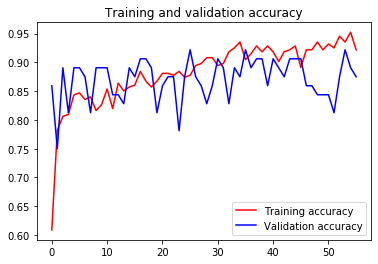

<Figure size 432x288 with 0 Axes>

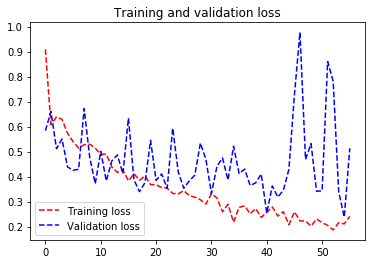

<Figure size 432x288 with 0 Axes>

In [11]:
#look at the metrics from training
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss') 
plt.legend(loc=0)
plt.figure()
plt.show()

In [53]:
#save the model
filepath = './saved_VGG16_retrain_slower'
model.save(filepath)

#load model
# model = tf.keras.models.load_model(filepath, compile = True)

INFO:tensorflow:Assets written to: ./saved_VGG16_retrain_slower/assets


In [13]:
#test the model

#define test directory
test_dir_wash = '../data/testing_michael/wash/'
test_dir_nowash = '../data/testing_michael/nowash'

#load images for wash
w_test = []
w_images = []
for img in os.listdir(test_dir_wash):
    #pull the name of the image
    w_images.append(img)
    #pull the image
    img = os.path.join(test_dir_wash, img)
    img = tf.keras.preprocessing.image.load_img(img,target_size = imsize)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img,axis=0)
    w_test.append(img)

#load images for nowash
nw_test = []
nw_images = []
for img in os.listdir(test_dir_nowash):
    #pull the name of the image
    nw_images.append(img)
    #pull the image
    img = os.path.join(test_dir_nowash, img)
    img = tf.keras.preprocessing.image.load_img(img,target_size = imsize)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img,axis=0)
    nw_test.append(img)


In [14]:
#make predictions 
w_test = np.vstack(w_test)
w_preds = model.predict(w_test)

nw_test = np.vstack(nw_test)
nw_preds = model.predict(nw_test)

In [15]:
#stack up the predicitons and truth in the same format

#vstack pred array
all_pred = np.vstack((w_preds,nw_preds))
all_pred = all_pred > 0.5

#vstack true array
all_obs = np.vstack((np.full((70,1), True), np.full((70,1), False)))

In [16]:
#report relevant binary classification stats for test data
report = metrics.classification_report(all_obs, all_pred)
print(report)

              precision    recall  f1-score   support

       False       0.88      0.96      0.92        70
        True       0.95      0.87      0.91        70

    accuracy                           0.91       140
   macro avg       0.92      0.91      0.91       140
weighted avg       0.92      0.91      0.91       140



In [17]:
#and the confusion matrix for test data
CM = metrics.confusion_matrix(all_obs, all_pred)
CM

array([[67,  3],
       [ 9, 61]])

In [18]:
#check the 4 categories of the Conf. Matrix
tn, fp, fn, tp = CM.ravel()
(tn, fp, fn, tp)

(67, 3, 9, 61)

In [19]:
#make labels into an array (wash then nowash)
nw_images = np.vstack((np.asarray(nw_images)))
w_images = np.vstack((np.asarray(w_images)))
all_images = np.vstack((w_images, nw_images))

#make single df for image names, true class, and predicted class 
#data = np.hstack((all_labels, all_true, all_pred))
results_df = pd.DataFrame(np.hstack((all_images, all_obs, all_pred)), columns=["Image", "Observed", "Predicted"])
results_df.head()

Image Observed Predicted
0  P28462771.jpg     True     False
1  P28462380.jpg     True      True
2  P28463002.jpg     True      True
3  P28463062.jpg     True      True
4  P28463052.jpg     True      True

In [20]:
#save the df as a csv
#results_df.to_csv('../data/test_results/VGG16_retrain.csv', index=False)

In [21]:
#FALSE NEGATIVES
#FN = results_df[(results_df['Observed'] == 'True') & (results_df['Predicted'] == 'False')]
#FN.head()

In [22]:
#FALSE POSITIVES
FP = results_df[(results_df['Observed'] == 'False') & (results_df['Predicted'] == 'True')]
FP.head()

Image Observed Predicted
91   S28466772.jpg    False      True
105  S28467936.jpg    False      True
119  P28460745.jpg    False      True

In [23]:
#TRUE POSITIVES
TP = results_df[(results_df['Observed'] == 'True') & (results_df['Predicted'] == 'True')]
TP

Image Observed Predicted
1   P28462380.jpg     True      True
2   P28463002.jpg     True      True
3   P28463062.jpg     True      True
4   P28463052.jpg     True      True
5   S28464234.jpg     True      True
..            ...      ...       ...
65  S28473814.jpg     True      True
66  P28462661.jpg     True      True
67  P28462390.jpg     True      True
68  P28462972.jpg     True      True
69  P28462951.jpg     True      True

[61 rows x 3 columns]

In [24]:
last_conv_layer_name = "block5_pool"
classifier_layer_names = [
    "flatten",
    "dense",
    "dropout",
    "dense_1",
]

In [62]:
# WASHOVER Images #
img_path = "../data/testing_michael/wash/P28463002.jpg"

img_path = "../data/testing_michael/wash/P28463052.jpg"
img_path = "../data/testing_michael/wash/S28464234.jpg"
img_path = "../data/testing_michael/wash/P28462661.jpg"

#false negative
#img_path = "../data/testing_michael/wash/P28462771.jpg"


#False Positive
#img_path = "../data/testing_michael/nowash/S28468543.jpg"
#img_path = "../data/testing_michael/nowash/P28461817.jpg"
#img_path = "../data/testing_michael/nowash/P28461827.jpg"
#img_path = "../data/testing_michael/nowash/S28468225.jpg"

# True negative Images

#img_path = "../data/testing_michael/nowash/P28460625.jpg"
#img_path = "../data/testing_michael/nowash/C28464775.jpg"


display(Image(img_path))

In [63]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size = imsize)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

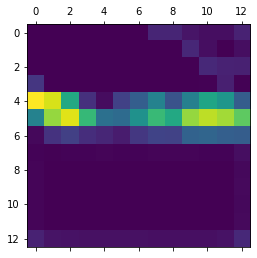

In [64]:
# Prepare image

img = tf.keras.preprocessing.image.load_img(img_path,target_size = imsize)
img = tf.keras.preprocessing.image.img_to_array(img)
img = img/255
img_array = np.expand_dims(img,axis=0)


# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()


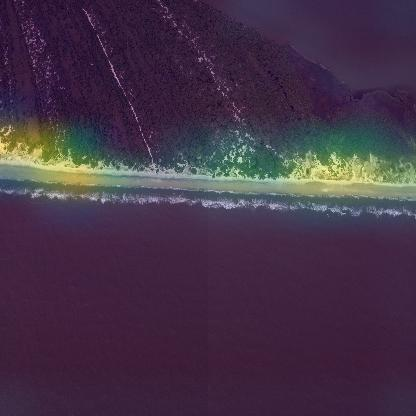

In [65]:
# We load the original image
Orimg = tf.keras.preprocessing.image.load_img(img_path, target_size = imsize)
Orimg = tf.keras.preprocessing.image.img_to_array(Orimg)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
vir = cm.get_cmap("viridis")

# We use RGB values of the colormap
vir_colors = vir(np.arange(256))[:, :3]
vir_heatmap = vir_colors[heatmap]

# We create an image with RGB colorized heatmap
vir_heatmap = tf.keras.preprocessing.image.array_to_img(vir_heatmap)
vir_heatmap = vir_heatmap.resize((Orimg.shape[1], Orimg.shape[0]))
vir_heatmap = tf.keras.preprocessing.image.img_to_array(vir_heatmap)

# Superimpose the heatmap on original image
superimposed_img = vir_heatmap * 0.4 + Orimg
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = '../data/gradcam/testVGG.jpg'
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))